在这个工作是是将航班频次作为边的权重

# 加载数据

In [1]:
import pandas as pd
# 加载数据
# data = pd.read_csv('../my/hh_result/result_all.csv', dtype={'flt_no': str})
# data_24 = pd.read_csv('../my/hh_result/result_24_7-10.csv', dtype={'flt_no': str})
data = pd.read_csv('../result/pre_2023-2025_with_comp.csv', dtype={'flt_no': str})

# 查看前几行数据，确保加载成功
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394012 entries, 0 to 2394011
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   flt_no            object 
 1   cap               float64
 2   aircraft          object 
 3   legs              int64  
 4   leg_no            int64  
 5   duration          float64
 6   pax               int64  
 7   a                 object 
 8   b                 object 
 9   c                 object 
 10  unit_price        float64
 11  competitor_price  float64
 12  year              int64  
 13  month             int64  
 14  day               int64  
 15  weekday           int64  
 16  hour              int64  
 17  minute            int64  
 18  from              object 
 19  to                object 
dtypes: float64(4), int64(9), object(7)
memory usage: 365.3+ MB
None


## 统计不同城市的频率

In [2]:
# 将 from 和 to 两列合并，并统计每个城市的出现次数
city_count_series = pd.concat([data['from'], data['to']]).value_counts()

# 转换为 city_count 数据框
city_count = city_count_series.reset_index()
city_count.columns = ['city', 'count']

# 3. 创建 city_map，将每个城市映射为其出现次数（或者任何你需要的值）
city_map = dict(zip(city_count['city'], city_count['count']))

# 输出结果
print(city_count)

    city   count
0    e5a  202608
1    dcf  139424
2    24c  120560
3    a2e  114834
4    ea1  110103
..   ...     ...
373  a49       1
374  bba       1
375  430       1
376  f91       1
377  0c8       1

[378 rows x 2 columns]


In [3]:
import json

# 保存 city_map 到 JSON 文件
with open('../result/encoder/city_map_频率编码.json', 'w') as f:
    json.dump(city_map, f)

print("city_map_频率编码 已保存到 city_map_频率编码")

city_map_频率编码 已保存到 city_map_频率编码


### 'flt_no', 'bd_type', 'aircraft'编码

In [4]:
import joblib
from sklearn.preprocessing import LabelEncoder
import os

# 定义需要编码的分类特征
# categorical_columns = ['flt_no', 'bd_type', 'aircraft', 'a', 'b', 'c', 'from', 'to']
# categorical_columns = ['flt_no', 'bd_type', 'aircraft']
categorical_columns = ['flt_no', 'aircraft']


# 创建并应用 LabelEncoder
label_encoders = {}

# 创建保存编码器的文件夹（如果文件夹不存在）
save_folder = '../result/encoder/'
os.makedirs(save_folder, exist_ok=True)  # 如果文件夹已存在，不会报错

# 遍历每个分类特征，使用 LabelEncoder 对其进行编码
for col in categorical_columns:
    le = LabelEncoder()  # 创建一个 LabelEncoder 实例
    data[col] = le.fit_transform(data[col])  # 对训练数据中的分类特征进行编码
    label_encoders[col] = le  # 将每个特征的编码器保存到字典中，方便后续使用

    # 保存每个编码器到指定文件夹
    encoder_path = os.path.join(save_folder, f"{col}_encoder_all.pkl")  # 构建保存路径
    joblib.dump(le, encoder_path)  # 使用 joblib 将编码器保存为 pkl 文件
    print(f"{col} 的编码器已保存为 {encoder_path}")  # 输出保存的路径

flt_no 的编码器已保存为 ../result/encoder/flt_no_encoder_all.pkl
aircraft 的编码器已保存为 ../result/encoder/aircraft_encoder_all.pkl


## 生成加权图

In [5]:
# 创建一个新的数据框，用于存储航班频数
flight_counts = data.groupby(['from', 'to']).size().reset_index(name='flight_count')

# 打印查看
print(flight_counts.shape)
print(flight_counts.head())


(2765, 3)
  from   to  flight_count
0  000  13f           285
1  000  8e3           882
2  000  a18             1
3  000  eda           434
4  01a  b5a            75


In [6]:
import networkx as nx

# 创建一个空图
G = nx.Graph()

# 将城市作为节点，航班频数作为边的权重添加到图中
for index, row in flight_counts.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['flight_count'])

# 输出图的基本信息
print("图的节点数:", G.number_of_nodes())
print("图的边数:", G.number_of_edges())

图的节点数: 378
图的边数: 2765


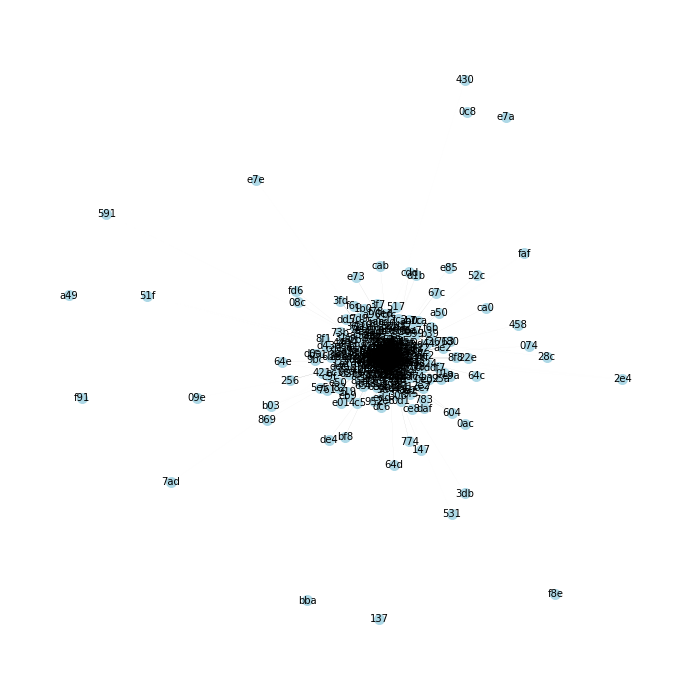

In [7]:
import matplotlib.pyplot as plt

# 设置图的布局
plt.figure(figsize=(12, 12))

# 绘制加权图，边的宽度表示航班频数
pos = nx.spring_layout(G, k=0.5)  # 使用 spring 布局来可视化图
edges = G.edges(data=True)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')

# 绘制边，边的宽度表示航班频数（weight）
nx.draw_networkx_edges(G, pos, width=[d['weight'] / 1000 for u, v, d in edges], alpha=0.5)

# 绘制节点标签
nx.draw_networkx_labels(G, pos, font_size=10)

# 显示图形
plt.title("加权航班网络图")
plt.axis('off')
plt.show()

## 创建并训练 DeepWalk 模型

In [8]:
import numpy
print(numpy.__version__)

1.21.6


In [9]:
import networkx as nx
from node2vec import Node2Vec

1. 加载图并准备数据

In [10]:
node2vec = Node2Vec(G, 
                   dimensions=64, 
                   walk_length=3, 
                   num_walks=500, 
                   workers=1,
                   weight_key='weight')

model = node2vec.fit(window=3, 
                    min_count=1, 
                    batch_words=64)

Computing transition probabilities:   0%|          | 0/378 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 500/500 [00:14<00:00, 33.89it/s]


2. 获取节点的嵌入向量

In [11]:
# 获取城市嵌入表示
city_embeddings = {}
for city in G.nodes():
    city_embeddings[city] = model.wv[city]  # 从模型中提取城市嵌入

# 打印第一个城市的嵌入表示
print(city_embeddings[list(G.nodes())[0]])

[ 0.296928   -0.40654936  0.7949411  -0.55770767 -0.05933169 -1.0337528
 -0.97748137 -0.5492395  -0.97783595  0.03830481 -0.05700088 -0.0636319
 -0.2002826   0.17247963  0.4387461   0.38685375 -0.10926761 -0.5854443
 -0.08772231  0.22793499  1.1342684   0.35799155  0.35671452 -0.32322773
 -0.08761074  0.28081733 -1.0170181   0.61906236  0.45937133  0.21498865
  0.23497325 -0.3556413   0.13261919 -0.27311072 -0.08549811  0.58714265
  0.49198183 -0.19492252 -0.03251059 -0.19897294  0.0583832   0.26212612
 -0.6753431  -0.11115886 -0.45215428 -0.19986778 -0.62905025 -0.36480343
  0.33398417  0.0989739  -0.9906426   0.22203532  0.13163096  0.5869277
  0.37275058 -0.02907437 -0.06695575 -0.5012075  -0.2465796   0.18968537
 -0.34253657 -0.94382954 -0.13907926  0.1883575 ]


city_embeddings是一个字典

## 进行聚类

步骤 3：使用嵌入向量进行下游任务（例如聚类）

In [12]:
from sklearn.cluster import KMeans
import numpy as np

# 提取嵌入向量
embeddings = np.array([city_embeddings[city] for city in G.nodes()])

# 使用 KMeans 聚类
kmeans = KMeans(n_clusters=3, random_state=42)  # 设置簇的数量为3
kmeans.fit(embeddings)

# 查看每个城市的聚类标签
city_labels = dict(zip(G.nodes(), kmeans.labels_))

# 打印城市及其对应的聚类标签
for city, label in city_labels.items():
    print(f"城市: {city}, 聚类标签: {label}")


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=Tru

城市: 000, 聚类标签: 2
城市: 13f, 聚类标签: 1
城市: 8e3, 聚类标签: 1
城市: a18, 聚类标签: 1
城市: eda, 聚类标签: 2
城市: 01a, 聚类标签: 2
城市: b5a, 聚类标签: 1
城市: ea1, 聚类标签: 1
城市: 03f, 聚类标签: 2
城市: 1be, 聚类标签: 1
城市: 3bc, 聚类标签: 1
城市: 578, 聚类标签: 1
城市: 5df, 聚类标签: 1
城市: 5fb, 聚类标签: 1
城市: 760, 聚类标签: 1
城市: 792, 聚类标签: 1
城市: 7ff, 聚类标签: 1
城市: 90a, 聚类标签: 1
城市: 974, 聚类标签: 1
城市: bbb, 聚类标签: 1
城市: cb5, 聚类标签: 1
城市: ffe, 聚类标签: 1
城市: 059, 聚类标签: 2
城市: 022, 聚类标签: 1
城市: 077, 聚类标签: 1
城市: 0d7, 聚类标签: 1
城市: 0dd, 聚类标签: 1
城市: 1a3, 聚类标签: 1
城市: 1e9, 聚类标签: 1
城市: 1ed, 聚类标签: 1
城市: 25c, 聚类标签: 1
城市: 311, 聚类标签: 1
城市: 354, 聚类标签: 1
城市: 451, 聚类标签: 1
城市: 510, 聚类标签: 1
城市: 5d7, 聚类标签: 2
城市: 63a, 聚类标签: 1
城市: 666, 聚类标签: 0
城市: 6e3, 聚类标签: 0
城市: 7f1, 聚类标签: 1
城市: 812, 聚类标签: 1
城市: 8a1, 聚类标签: 1
城市: 9d4, 聚类标签: 2
城市: 9e9, 聚类标签: 1
城市: b3a, 聚类标签: 1
城市: bff, 聚类标签: 1
城市: c24, 聚类标签: 1
城市: c3a, 聚类标签: 1
城市: c4c, 聚类标签: 1
城市: c98, 聚类标签: 1
城市: c9f, 聚类标签: 1
城市: cb7, 聚类标签: 1
城市: d7c, 聚类标签: 1
城市: e76, 聚类标签: 1
城市: e9c, 聚类标签: 1
城市: efb, 聚类标签: 1
城市: 05c, 聚类标签: 2
城市: 141, 聚类标签: 1
城市: 157, 聚类标签:

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:400: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:400: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

### 保存聚类标签

In [13]:
# 首先导入 json 模块
import json
print(city_labels)

# 将字典中的所有值转换为 Python 的原生 int 类型
city_labels = {key: int(value) for key, value in city_labels.items()}

# 保存字典到 JSON 文件
with open('../result/encoder/city_labels_航班频率加权图标签.json', 'w') as file:
    json.dump(city_labels, file)

print("字典已保存为 city_labels.json")

{'000': 2, '13f': 1, '8e3': 1, 'a18': 1, 'eda': 2, '01a': 2, 'b5a': 1, 'ea1': 1, '03f': 2, '1be': 1, '3bc': 1, '578': 1, '5df': 1, '5fb': 1, '760': 1, '792': 1, '7ff': 1, '90a': 1, '974': 1, 'bbb': 1, 'cb5': 1, 'ffe': 1, '059': 2, '022': 1, '077': 1, '0d7': 1, '0dd': 1, '1a3': 1, '1e9': 1, '1ed': 1, '25c': 1, '311': 1, '354': 1, '451': 1, '510': 1, '5d7': 2, '63a': 1, '666': 0, '6e3': 0, '7f1': 1, '812': 1, '8a1': 1, '9d4': 2, '9e9': 1, 'b3a': 1, 'bff': 1, 'c24': 1, 'c3a': 1, 'c4c': 1, 'c98': 1, 'c9f': 1, 'cb7': 1, 'd7c': 1, 'e76': 1, 'e9c': 1, 'efb': 1, '05c': 2, '141': 1, '157': 1, '709': 1, '8ac': 0, '97f': 1, '988': 1, 'a2f': 1, 'b09': 1, 'c14': 1, 'c4b': 0, 'e5b': 1, 'ec2': 1, '074': 2, '4d0': 1, '695': 1, 'c2c': 1, 'fa9': 1, '08c': 2, '08f': 2, '3c5': 1, '5e8': 1, 'a72': 1, 'd54': 1, 'ff1': 1, '0ac': 2, '0c8': 2, '0ca': 0, 'e09': 0, '0d1': 2, '13e': 1, '1ee': 1, '43e': 1, '0db': 2, '919': 1, 'd08': 1, '0ff': 2, '11b': 0, '123': 2, '5de': 1, '8eb': 1, '124': 2, '130': 2, '1bf': 1,

## 二维空间聚类效果展示

步骤 4：可视化嵌入

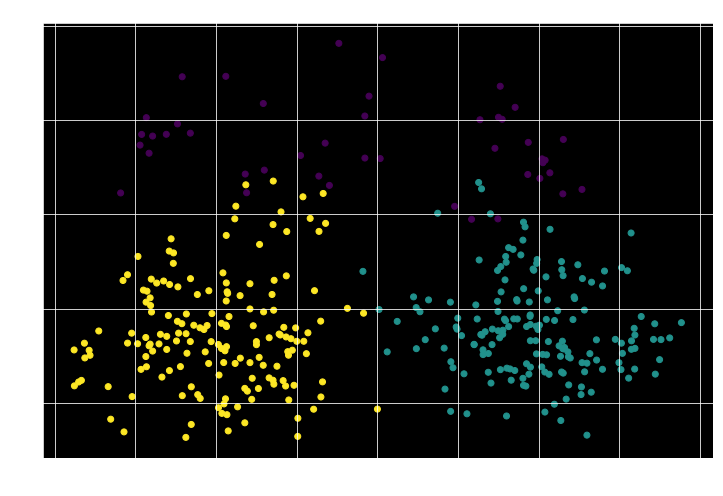

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 使用 PCA 降维到 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# 绘制散点图
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_, cmap='viridis')

# 去掉为每个城市添加标签的部分
# for i, city in enumerate(G.nodes()):
#     plt.text(reduced_embeddings[i, 0] + 0.1, reduced_embeddings[i, 1] + 0.1, city, fontsize=9)

plt.title("DeepWalk - City Embeddings (2D PCA visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# 计算城市之间的相似度
similarity_matrix = cosine_similarity(embeddings)

# 打印第一个城市和其他城市的相似度
for i, city in enumerate(G.nodes()):
    print(f"城市: {city}, 相似度: {similarity_matrix[0, i]}")

城市: 000, 相似度: 1.0
城市: 13f, 相似度: 0.28257516026496887
城市: 8e3, 相似度: 0.4271388053894043
城市: a18, 相似度: 0.06992663443088531
城市: eda, 相似度: 0.4810965061187744
城市: 01a, 相似度: 0.48189035058021545
城市: b5a, 相似度: 0.13366518914699554
城市: ea1, 相似度: 0.16292385756969452
城市: 03f, 相似度: 0.3189886808395386
城市: 1be, 相似度: 0.16406592726707458
城市: 3bc, 相似度: 0.13307178020477295
城市: 578, 相似度: 0.03812779113650322
城市: 5df, 相似度: 0.19078269600868225
城市: 5fb, 相似度: 0.15188385546207428
城市: 760, 相似度: 0.13699497282505035
城市: 792, 相似度: 0.18633529543876648
城市: 7ff, 相似度: 0.1505606323480606
城市: 90a, 相似度: 0.08488572388887405
城市: 974, 相似度: 0.135574072599411
城市: bbb, 相似度: 0.1793745458126068
城市: cb5, 相似度: 0.1480700820684433
城市: ffe, 相似度: 0.17728902399539948
城市: 059, 相似度: 0.15314483642578125
城市: 022, 相似度: 0.2734166085720062
城市: 077, 相似度: 0.1702008694410324
城市: 0d7, 相似度: 0.11787805706262589
城市: 0dd, 相似度: 0.08019813895225525
城市: 1a3, 相似度: 0.1464202105998993
城市: 1e9, 相似度: 0.20964880287647247
城市: 1ed, 相似度: 0.14214128255844116
城市: 25c

轮廓系数是评估聚类质量的常用指标，范围是 -1 到 1，值越大表示聚类效果越好。它同时考虑了簇内紧密度（每个点与所在簇中其他点的距离）和簇间分离度（每个点与最近簇的距离）。

值的意义：

值接近 +1：说明数据点与同簇内的点很接近，且与其他簇的点有很大区别，聚类效果好。

值接近 0：表示数据点可能位于两个簇的边界上，聚类效果一般。

值接近 -1：表示数据点可能被错误地归类到某个簇中，聚类效果差。

In [16]:
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_embeddings, kmeans.labels_)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.5294318795204163


## 保存嵌入表示

In [17]:
import numpy as np
import json

# 获取城市列表
cities = list(city_embeddings.keys())

# 将降维后的嵌入表示转换为列表格式
reduced_embeddings_list = reduced_embeddings.tolist()

# 保存城市和其对应的嵌入（将 NumPy 数组转换为列表）
city_embedding_dict = {city: reduced_embeddings[i].tolist() for i, city in enumerate(cities)}

# 将 city_embedding_dict 保存为 JSON 文件
with open('../result/encoder/城市嵌入编码_航班频率加权图.json', 'w') as f:
    json.dump(city_embedding_dict, f)

print("城市嵌入表示已保存。")

城市嵌入表示已保存。


In [18]:
city_embedding_dict

{'000': [-1.6396723985671997, 0.8463003039360046],
 '13f': [0.6835631728172302, 0.28853702545166016],
 '8e3': [0.605768084526062, 0.43108901381492615],
 'a18': [0.1772567182779312, 0.35664066672325134],
 'eda': [-0.18683721125125885, 0.786605715751648],
 '01a': [-1.6955363750457764, 0.015374363400042057],
 'b5a': [0.6262921690940857, 0.6344022154808044],
 'ea1': [0.2808123230934143, -0.011203848756849766],
 '03f': [-0.929985761642456, 1.23349928855896],
 '1be': [0.8312583565711975, 0.8889409899711609],
 '3bc': [1.4587459564208984, 1.2139819860458374],
 '578': [0.9716920256614685, 0.5555941462516785],
 '5df': [0.8122007846832275, 1.0064148902893066],
 '5fb': [0.7514726519584656, 0.360472708940506],
 '760': [1.288560390472412, 0.6948064565658569],
 '792': [0.14092816412448883, 0.706443727016449],
 '7ff': [1.017447829246521, 0.27192866802215576],
 '90a': [0.07465023547410965, 0.3252807855606079],
 '974': [1.2340888977050781, 0.8395470380783081],
 'bbb': [0.4277801811695099, 0.777651786804